# Chap 2: How much should I order

## 2.5: Extensions of EOQ

In [2]:
def EOQ(k, D, h, c): # h is a percentage
    """
    Calculate the Economic Order Quantity (EOQ).

    Parameters:
    k (float): Cost per order
    D (float): Demand rate (units per year)
    h (float): Holding cost per unit per year
    c (float): Cost per unit

    Returns:
    float: The optimal order quantity
    """
    return ((2 * k * D) / (h * c)) ** 0.5

def Cost(k,D,h,Q,c): # h is a percentage
    """
    Calculate the total cost of inventory.

    Parameters:
    k (float): Cost per order
    D (float): Demand rate (units per year)
    h (float): Holding cost per unit per year
    Q (float): Order quantity
    c (float): Cost per unit

    Returns:
    float: The total cost
    """
    return (k * (D / Q)) + (h * c * (Q / 2)) + (c * D)

#Case 1
c, k, D, h = 1, 100, 2000, 0.15
Q = EOQ(k, D, h, c)
C = Cost(k, D, h, Q, c)
print(f"Case 1: EOQ = {Q:.2f}, Total Cost = {C:.2f}")

#Case 2
c = 0.8
Q = max(200, EOQ(k, D, h, c))
C = Cost(k, D, h, Q, c)
print(f"Case 2: EOQ = {Q:.2f}, Total Cost = {C:.2f}")

Case 1: EOQ = 1632.99, Total Cost = 2244.95
Case 2: EOQ = 1825.74, Total Cost = 1819.09


# Chap 5: Inventory policy

## 5.3: Fill rate

     Demand  On-Hand                In-Transit
5       103       92  [57, 125, 101, 114, 103]
6        90       59  [125, 101, 114, 103, 90]
7       120       64  [101, 114, 103, 90, 120]
8        78       87   [114, 103, 90, 120, 78]
9       105       96   [103, 90, 120, 78, 105]
..      ...      ...                       ...
195      98       79   [107, 116, 106, 86, 98]
196      75      111    [116, 106, 86, 98, 75]
197      72      155     [106, 86, 98, 75, 72]
198      74      187      [86, 98, 75, 72, 74]
199     141      132     [98, 75, 72, 74, 141]

[195 rows x 3 columns]
Alpha: 95.0
Cycle Service Level: 95.9
Period Service Level: 96.0


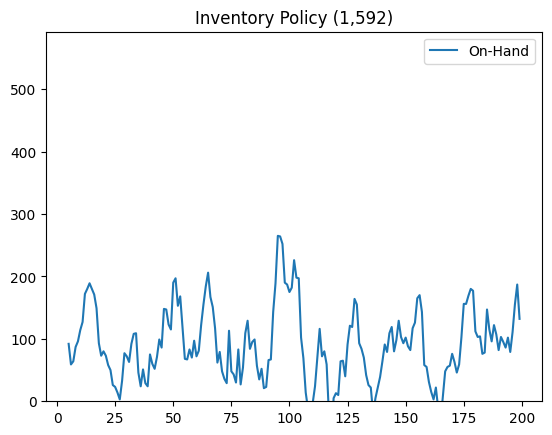

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Demmand parameters (demand follows a normal distribution with mean=100 and std=25)
time=200
d_mu=100
d_std=25

# Inventory policy parameters
d = np.maximum(np.random.normal(d_mu,d_std,time).round(0).astype(int), 0)
L, R, alpha = 4, 1, 0.95
z = norm.ppf(alpha)
x_std = np.sqrt(L+R)*d_std
Ss=np.round(x_std*z).astype(int)
Cs=1/2*d_mu*R
Is=d_mu*L
S=Ss+2*Cs+Is


# Track of the on-hand and in-transit inventory
hand=np.zeros(time,dtype=int)
transit=np.zeros((time,L+1),dtype=int)

# Track the service level of our inventory policy
stockout_period = np.full(time, False, dtype=bool)
stockout_cycle = []

# Initialize the inventory (on-hand and in-transit)
hand[0]=S-d[0]
transit[1,-1]=d[0]

# Start the simulation
for t in range(1,time):
    if transit[t-1,0]>0:
        stockout_cycle.append(stockout_period[t-1])
    hand[t]=hand[t-1]-d[t]+transit[t-1,0]
    stockout_period[t]=hand[t]<0
    #hand[t]=max(0,hand[t]) # Uncomment this line to avoid negative inventory (if excess demand result in lost sales rather than backorders)
    transit[t,:-1]=transit[t-1,1:]
    if 0==t%R:
        net=hand[t]+transit[t].sum()
        transit[t,L]=S-net

# Create a DataFrame to store the results
df = pd.DataFrame(data={
    'Demand':d,
    'On-Hand':hand,
    'In-Transit':list(transit),
})

df = df.iloc[R+L:,:] # Remove the first R+L periods (initialization periods) to avoid bias 

print(df)

df['On-Hand'].plot(title='Inventory Policy (%d,%d)'%(R,S), ylim=(0, S), legend=True)

print('Alpha:', alpha*100)
SL_alpha=1-sum(stockout_cycle)/len(stockout_cycle)
print('Cycle Service Level:', round(SL_alpha*100,1))
SL_period=1-sum(stockout_period)/time
print('Period Service Level:', round(SL_period*100,1))

# Chap 7: Fill rate

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def normal_loss(inv, mu, stddev):
    """
    Calculate the normal loss for an inventory.

    Parameters:
    inv (float): inventory amount.
    mu (float): Mean return of the inventory.
    stddev (float): Standard deviation of the returns.

    Returns:
    float: Normal loss value.
    """
    return stddev**2*norm.pdf(inv, loc=mu, scale=stddev) + (mu-inv)*(1-norm.cdf(inv, loc=mu, scale=stddev))


# teste
inv = 120
mu = 100
stddev = 50
print(f"Normal loss for inventory {inv} with mean {mu} and stddev {stddev}: {normal_loss(inv, mu, stddev)}")

def normal_loss_standard(x):
    """
    Calculate the normal loss for a standardized inventory.

    Parameters:
    x (float): Standardized inventory amount.

    Returns:
    float: Normal loss value.
    """
    return norm.pdf(x) - (1 - norm.cdf(x)) * x

# teste
inv = 120
mu = 100
stddev = 50
print(f"Normal loss for inventory {inv} with mean {mu} and stddev {stddev}: {stddev*normal_loss_standard((inv-mu)/ stddev)}")

# Exemplo
inv, x_mu, x_stddev = 270, 250, 30
lost= normal_loss(inv, x_mu, x_stddev)
print(f"Normal loss for inventory {inv} with mean {x_mu} and stddev {x_stddev}: {lost}")

z=(inv-x_mu)/x_stddev
alpha = norm.cdf(z)
print(f"Alpha for inventory {inv} with mean {x_mu} and stddev {x_stddev}: {alpha}")

# Inverse loss function

from scipy import optimize

d_c, x_std, beta = 100, 50, 0.99
target = d_c * (1 - beta)/x_std

def f(x):
    """
    Function to find the inventory level that results in a specific loss.

    Parameters:
    x (float): Inventory level.

    Returns:
    float: The difference between the calculated loss and the target loss.
    """
    return abs(normal_loss_standard(x) - target)

result = optimize.minimize_scalar(f)#, bounds=(-10, 10), method='bounded')

print(result)

print(f"z: {result.x}, x_mu: {x_mu}, x_std: {x_std}, d_c: {d_c}, beta: {beta}")
print(f"Inventory level for target loss: {result.x * x_std + x_mu}")

Normal loss for inventory 120 with mean 100 and stddev 50: 11.521941847372652
Normal loss for inventory 120 with mean 100 and stddev 50: 11.52194184737265
Normal loss for inventory 270 with mean 250 and stddev 30: 4.53358941473211
Alpha for inventory 270 with mean 250 and stddev 30: 0.7475074624530771
 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 3.771691292620005e-10
       x: 1.6630509496216634
     nit: 23
    nfev: 27
z: 1.6630509496216634, x_mu: 250, x_std: 50, d_c: 100, beta: 0.99
Inventory level for target loss: 333.15254748108316


# Chap 8: Cost and service level optimization

## 8.2: (R,s) Policy

C:\Users\USER\AppData\Local\Temp\ipykernel_8044\2834591078.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


,Review Period,Inventory Cost,Cycle Service Level,Fill Rate
0,1,2534.185899,0.99,0.999732
1,2,2576.593802,0.98,0.999503
2,3,2956.267931,0.97,0.999285
3,4,3414.456375,0.96,0.999076
4,5,3900.176729,0.95,0.998878
5,6,4397.020329,0.94,0.998690
6,7,4898.313952,0.93,0.998514


<Axes: xlabel='Review Period'>

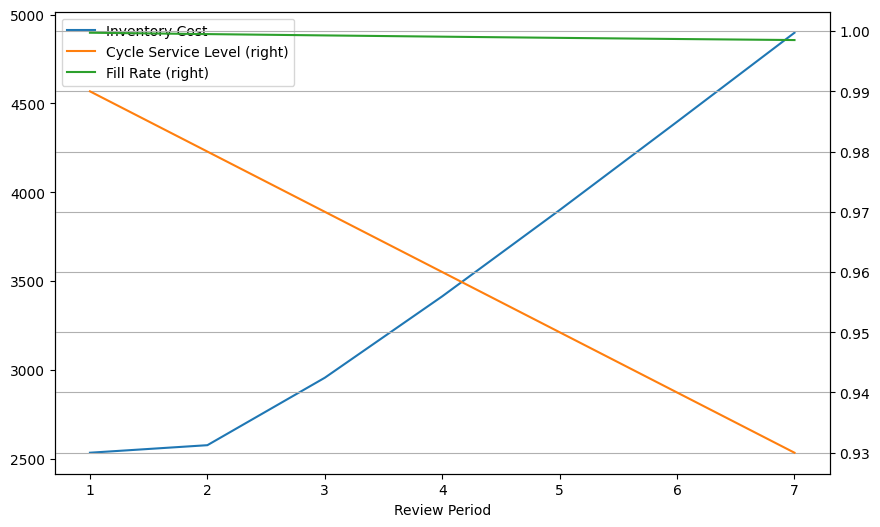

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm    

def normal_loss_standard(x):
    '''
    Computes the standard normal loss function for a given input x.
    The standard normal loss function is defined as:
    L(x) = x * (1 - Φ(x)) * φ(x)
    where φ(x) is the probability density function (PDF) of the standard normal distribution,
    and Φ(x) is the cumulative distribution function (CDF) of the standard normal distribution.
    This function uses the scipy.stats library to compute the PDF and CDF.

    Parameters:
    x : float or array-like
        The input value(s) for which to compute the loss.
    Returns:
    float or array-like
        The computed loss value(s).
    '''
    return norm.pdf(x) * x*(1-norm.cdf(x))

def cost(h, d_mu, R, z, x_std, k, b):
    '''
    Computes the cost function based on the provided parameters.
    The cost function is defined as:
    C(h, d_mu, R, z, x_std, k, b) = h * (d_mu * R / 2 + x_std * z) + k / R + b * x_std * L(z)
    where L(z) is the standard normal loss function evaluated at z.
    Parameters:
    h : float
        A scaling factor for the first term of the cost function.
    d_mu : float
        A parameter that scales the first term of the cost function.        
    R : float
        A parameter that scales the first term of the cost function and is also used in the second term.
    z : float or array-like
        The input value(s) for which to compute the loss.
    x_std : float
        A scaling factor for the second term of the cost function.
    k : float
        A constant term that is divided by R in the cost function.
    b : float
        A scaling factor for the third term of the cost function.
    Returns:
    float or array-like
        The computed cost value(s).
    '''
    return h*(d_mu*R/2+x_std*z)+k/R+b*x_std*normal_loss_standard(z)/R

def CSL_optimal(b,h,R):
    '''
    Computes the optimal value of the CSL (Cost-Saving Level) based on the provided parameters.
    The optimal CSL is defined as:
    CSL_optimal(b, h, R) = 1 - (h * R) / b
    where h is a scaling factor, R is a parameter that scales the cost function,
    and b is a scaling factor for the cost function.
    Parameters:
    b : float
        A scaling factor for the cost function.
    h : float
        A scaling factor for the cost function.
    R : float
        A parameter that scales the cost function.
    Returns:
    float
        The computed optimal CSL value.
    '''
    return 1-(h*R)/b

# Parameters
b = 1000  # Cost of lost sales
h = 10    # Holding cost per unit
d_mu = 100  # Mean demand per period
L = 2     # Lead time in periods
k = 1000  # Fixed cost per order

df=pd.DataFrame(columns=['Review Period','Inventory Cost','Cycle Service Level','Fill Rate'])
for R in [1,2,3,4,5,6,7]:
    x_std = 25*np.sqrt(R+L)
    alpha = CSL_optimal(b,h,R)
    z = norm.ppf(alpha)
    beta = 1-x_std*normal_loss_standard(z)/R/d_mu
    # Criando uma linha como DataFrame e concatenando
    new_row = pd.DataFrame([{
        'Review Period': R,
        'Inventory Cost': cost(h, d_mu, R, z, x_std, k, b),
        'Cycle Service Level': alpha,
        'Fill Rate': beta
    }])
    
    df = pd.concat([df, new_row], ignore_index=True)

display(df)

df.plot(y=['Inventory Cost', 'Cycle Service Level', 'Fill Rate'],x='Review Period',secondary_y=['Cycle Service Level', 'Fill Rate'], figsize=(10, 6), grid=True)

## 8.3 (s,Q) Policy

In [6]:
def normal_loss_standard(x):
    """
    Calculate the standard normal loss for a standardized inventory.

    Parameters:
    x (float): Standardized inventory amount.

    Returns:
    float: Normal loss value.
    """
    return norm.pdf(x) - x * (1 - norm.cdf(x))

def EOQ(k, D, h): 
    """
    Calculate the Economic Order Quantity (EOQ).

    Parameters:
    k (float): Cost per order
    D (float): Demand rate (units per year)
    h (float): Holding cost per unit per year

    Returns:
    float: The optimal order quantity
    """
    return ((2 * k * D) / h) ** 0.5

def CSL_optimal(b, h, Q, D):
    """
    Calculate the optimal Cycle Service Level (CSL).

    Parameters:
    b (float): Cost of lost sales
    h (float): Holding cost per unit per year
    Q (float): Order quantity
    D (float): Demand rate (units per year)

    Returns:
    float: The optimal Cycle Service Level
    """
    return 1 - (h * Q) / (b * D)

def Q_optimal(k,D,h,b,z,x_std):
    """
    Calculate the optimal order quantity based on the given parameters.

    Parameters:
    k (float): Cost per order
    D (float): Demand rate (units per year)
    h (float): Holding cost per unit per year
    b (float): Cost of lost sales
    z (float): Standardized inventory level
    x_std (float): Standard deviation of the inventory

    Returns:
    float: The optimal order quantity
    """
    return (2*(k+b*x_std*normal_loss_standard(z))*D/h)**0.5

def sQ_optimal(k, D, h, b, z, x_std):
    """
    Calculate the optimal reorder point based on the given parameters.

    Parameters:
    k (float): Cost per order
    D (float): Demand rate (units per year)
    h (float): Holding cost per unit per year
    b (float): Cost of lost sales
    x_std (float): Standard deviation of the inventory

    Returns:
    float: The optimal reorder point
    """
    Q = EOQ(k, D, h)
    Q_old=0
    while abs(Q-Q_old)>0.0001:
        Q_old=Q
        z = norm.ppf(CSL_optimal(b, h, Q, D))
        Q = round(Q_optimal(k, D, h, b, z, x_std))
    return z,Q

# Running simulation
k= 1000  # Cost per order (fixed cost of transaction)
D = 100*52 # Demand rate (units per year) - Yearly demand
h = 1.25*52 # Holding cost per unit per year 
b = 50  # Cost of lost sales (cost of backordering one unit)
x_std = 25 # Demand deviation over the risk period

print(f"Parameters: k={k}, D={D}, h={h}, b={b}, x_std={x_std}")
z, Q = sQ_optimal(k, D, h, b, 0, x_std)
print(f"Optimal reorder point (z): {z}, Optimal order quantity (Q): {Q}")

Parameters: k=1000, D=5200, h=65.0, b=50, x_std=25
Optimal reorder point (z): 1.2646411356610803, Optimal order quantity (Q): 412


## 8.4 Simulation

In [8]:
import numpy as np
from scipy import optimize
from scipy.stats import norm

# ---------------------------
# Funções auxiliares
# ---------------------------
def normal_loss_standard(z):
    """Função de perda padrão normalizada."""
    return norm.pdf(z) - z * (1 - norm.cdf(z))

def inverse_standard_loss(target):
    """Inverte a função de perda padrão normalizada."""
    def f(z):
        return abs(normal_loss_standard(z) - target)
    result = optimize.minimize_scalar(f, bounds=(-10, 10), method='bounded')
    return result.x

def cost(h, d_mu, R, z, x_std, k, b):
    """Estimativa do custo médio por período (teórico, seção 8.4.2)."""
    return h * (d_mu * R / 2 + x_std * z) + k / R + b * x_std * normal_loss_standard(z) / R

# ---------------------------
# Parâmetros do exemplo
# ---------------------------
k = 1000   # Custo por pedido
h = 1.25   # Custo de manutenção por unidade por período
b = 50     # Custo por unidade em falta
time = 200 # Períodos a simular

d_mu, d_std = 100, 25
L, R = 4, 1               # Lead time e período de revisão
beta = 0.95               # Nível de serviço alvo

# ---------------------------
# Cálculo do estoque de segurança e ponto de pedido (Seção 8.4.1)
# ---------------------------
x_std = np.sqrt(L + R) * d_std
target = (1 - beta)  # probabilidade de falta
z = inverse_standard_loss(target)
S = int(round(d_mu * (L + R) + z * x_std))  # Ponto de pedido
Q = int(round(d_mu * R))                    # Quantidade típica por ciclo

# ---------------------------
# Simulação (Seção 8.4)
# ---------------------------
d = np.maximum(np.random.normal(d_mu, d_std, time).round(0).astype(int), 0)

hand = np.zeros(time, dtype=int)           # Estoque disponível
transit = np.zeros((time, L + 1), dtype=int)  # Estoque em trânsito
unit_shorts = np.zeros(time, dtype=int)    # Faltas
p = np.zeros(time)                         # Estoque médio

c_k = 0
c_h = 0
c_b = 0

# Inicializa o estoque
hand[0] = S - d[0]
transit[1, -1] = d[0]
p[0] = max(hand[0], 0)

for t in range(1, time):
    # Atualiza estoques e faltas
    unit_shorts[t] = max(0, d[t] - max(0, hand[t-1] + transit[t-1, 0]))
    hand[t] = hand[t-1] - d[t] + transit[t-1, 0]

    # Move o pipeline de pedidos
    transit[t, :-1] = transit[t-1, 1:]

    # Reposição a cada R períodos
    if t % R == 0:
        actual_L = int(round(max(np.random.normal(L, 1), 0)))  # lead time variável
        actual_L = min(actual_L, L)  # evita index error
        net = hand[t] + transit[t].sum()
        transit[t, actual_L] = S - net
        c_k += k

    # Estoque médio p[t]
    if hand[t] > 0:
        p[t] = (hand[t-1] + transit[t-1, 0] + hand[t]) / 2
    else:
        p[t] = max(hand[t-1] + transit[t-1, 0], 0)**2 / max(d[t], 1) / 2

    # Custos acumulados
    c_h += h * p[t]
    c_b += b * unit_shorts[t]

# ---------------------------
# Resultados
# ---------------------------
print(f"--- Resultados Simulação (Seção 8.4) ---")
print(f"Ponto de Pedido (S): {S}")
print(f"Quantidade por ciclo (Q): {Q}")
print(f"Custo de Pedido: {c_k:.2f}")
print(f"Custo de Armazenagem: {c_h:.2f}")
print(f"Custo de Backorder: {c_b:.2f}")
print(f"Custo Total (simulado): {c_k + c_h + c_b:.2f}")

print(f"\n--- Custo Estimado (Seção 8.4.2) ---")
print(f"Custo Teórico por período: {cost(h, d_mu, R, z, x_std, k, b):.2f}")


--- Resultados Simulação (Seção 8.4) ---
Ponto de Pedido (S): 570
Quantidade por ciclo (Q): 100
Custo de Pedido: 199000.00
Custo de Armazenagem: 30725.10
Custo de Backorder: 117800.00
Custo Total (simulado): 347525.10

--- Custo Estimado (Seção 8.4.2) ---
Custo Teórico por período: 1289.99
